In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

powerfactory_path = r'C:\Program Files\DIgSILENT\PowerFactory 2020 SP4\Python\3.8'
if powerfactory_path not in sys.path:
    sys.path.append(powerfactory_path)
import powerfactory as pf

In [2]:
def get_simulation_variable(elements_name, var_name, app, res):
    n_samples = app.ResGetValueCount(res, 0)
    elements = app.GetCalcRelevantObjects(elements_name)
    variables = np.zeros((n_samples, len(elements)))
    for i,element in enumerate(elements):
        index = app.ResGetIndex(res, element, var_name)
        if index < 0:
            raise Exception(f'Variable {var_name} is not available.')
        variables[:,i] = np.array([app.ResGetData(res, j, index)[1] for j in range(n_samples)])
    return np.squeeze(variables)

def get_simulation_time(app, res):
    n_samples = app.ResGetValueCount(res, 0)
    return np.array([app.ResGetData(res, i, -1)[1] for i in range(n_samples)])

In [3]:
app = pf.GetApplication()
if app is None:
    raise Exception('Cannot get PowerFactory application')
    
project_name = 'PythonTutorial_Introduction'
err = app.ActivateProject(project_name)
if err:
    raise Exception(f'Cannot activate project {project_name}')
    
project = app.GetActiveProject()
if project is None:
    raise Exception('Cannot get active project')
    
project_folders = {}
for folder_name in ('study',):
    project_folders[folder_name] = app.GetProjectFolder(folder_name)
    if project_folders[folder_name] is None:
        raise Exception(f'No folder "{folder_name}" present')
        
study_case_name = 'Tran'
if '.IntCase' not in study_case_name:
    study_case_name += '.IntCase'
study_case = project_folders['study'].GetContents(study_case_name)[0]
err = study_case.Activate()

In [4]:
monitored_variables = {
    '*.ElmTerm': ['m:u', 'm:fe', 'm:fehz'],
    '*.ElmLod': ['m:Psum:bus1', 'm:Qsum:bus1'],
    '*.ElmSym': ['s:xspeed']
}
# the results of the transient simulation will be stored in this variable
res = app.GetFromStudyCase('*.ElmRes')
for elm_name,var_names in monitored_variables.items():
    for element in app.GetCalcRelevantObjects(elm_name):
        res.AddVars(element, *var_names)

In [5]:
load = app.GetCalcRelevantObjects('General Load 1.ElmLod')[0]
bus = app.GetCalcRelevantObjects('Terminal Load.ElmTerm')[0]
line = app.GetCalcRelevantObjects('*.ElmLne')[0]

event_folder = app.GetFromStudyCase('IntEvt')
events = {}
for event_name in 'param_change', 'short_circuit', 'clear_short':
    event_folder.CreateObject('EvtParam', event_name)
    evt = event_folder.GetContents(event_name + '.EvtParam')[0]
    if event_name == 'param_change':
        evt.p_target = load
        evt.variable = 'plini'
        evt.value = '10'
        evt.time = 2
    elif event_name == 'short_circuit':
        evt.p_target = line
        evt.i_shc = 0 # 3-phase short circuit
        evt.time = 1
    elif event_name == 'clear_short':
        evt.p_target = line
        evt.i_shc = 4 # clear short circuit
        evt.time = 1.1
    events[event_name] = evt

In [6]:
inc = app.GetFromStudyCase('ComInc')
inc.iopt_sim = 'rms'
inc.tstart = 0
inc.dtgrd = 0.1e-3
err = inc.Execute()
if err:
    raise Exception('Cannot compute initial condition')
print('Successfully computed initial condition.')

Successfully computed initial condition.


In [7]:
sim = app.GetFromStudyCase('ComSim')
sim.tstop = 5
err = sim.Execute()
if err:
    raise Exception('Cannot run transient simulation')
print('Successfully run transient simulation.')

Successfully run transient simulation.


In [8]:
for event in events.values():
    event.Delete()
app.ResLoadData(res)

In [9]:
generator = app.GetCalcRelevantObjects('*.ElmSym')[0]
generator.loc_name

'Synchronous Machine'

In [10]:
time = get_simulation_time(app, res)
# voltage = get_simulation_variable('Terminal Load.ElmTerm', 'm:u', app, res)
# fe = get_simulation_variable('Terminal Load.ElmTerm', 'm:fe', app, res)
speed = get_simulation_variable(generator.loc_name + '.ElmSym', 's:xspeed', app, res)

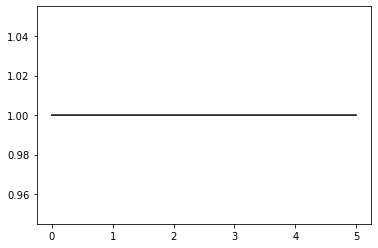

In [11]:
plt.plot(time, speed, 'k')